In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from urllib import request
from PIL import Image
import pickle
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
books=pd.read_csv('data/Books.csv', low_memory=False)
ratings=pd.read_csv('data/Ratings.csv')
users=pd.read_csv('data/Users.csv')

In [4]:
#First Step would be to perform basic EDA to understand our Data well

In [5]:
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [6]:
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [7]:
users.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [8]:
#There are no empty rows in Users dataframe
print(f'{ratings.isna().sum()}\n\nShape: {ratings.shape}')

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Shape: (1149780, 3)


In [9]:
print(f'{books.isna().sum()}\n\nShape: {books.shape}')

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Shape: (271360, 8)


In [10]:
#Merge rating and books dataframe on "ISBN" number
books_rated=ratings.merge(books,on="ISBN")
books_rated.drop(columns=['Image-URL-S','Image-URL-L'],inplace=True)
books_rated.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [11]:
print(f'books_rated shape:\n{books_rated.shape}\n\nunique entries: ')
print(books_rated['User-ID'].unique().shape)

books_rated shape:
(1031136, 8)

unique entries: 
(92106,)


In [12]:
#We dont need ISBN any more
books_rated.drop('ISBN',axis=1, inplace=True)

In [13]:
books_rated['Book-Rating'].value_counts(ascending=True)

1       1481
2       2375
3       5118
4       7617
6      31687
5      45355
9      60778
7      66402
10     71225
8      91804
0     647294
Name: Book-Rating, dtype: int64

In [14]:
books_rated[books_rated['Book-Rating']==10]['Book-Title'].value_counts().head(10)

The Da Vinci Code                                                   160
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))    152
Harry Potter and the Prisoner of Azkaban (Book 3)                   150
The Lovely Bones: A Novel                                           148
Harry Potter and the Chamber of Secrets (Book 2)                    139
Harry Potter and the Goblet of Fire (Book 4)                        136
To Kill a Mockingbird                                               133
Harry Potter and the Order of the Phoenix (Book 5)                  115
The Secret Life of Bees                                             112
The Fellowship of the Ring (The Lord of the Rings, Part 1)          103
Name: Book-Title, dtype: int64

In [15]:
#Most highly rated books
books_rated[books_rated['Book-Rating']==1]['Book-Title'].value_counts().head(10)

Wild Animus                                                                 74
Bridget Jones's Diary                                                        5
The Bridges of Madison County                                                5
Isle of Dogs                                                                 5
Black Coffee Blues                                                           4
Bleachers                                                                    4
The Lovely Bones                                                             3
Portrait of a Killer: Jack the Ripper-- Case Closed (Berkley True Crime)     3
Naked Lunch                                                                  3
Stupid White Men ...and Other Sorry Excuses for the State of the Nation!     3
Name: Book-Title, dtype: int64

In [16]:
#Most rated books
books_rated['Book-Title'].value_counts().head(10)

Wild Animus                                        2502
The Lovely Bones: A Novel                          1295
The Da Vinci Code                                   898
A Painted House                                     838
The Nanny Diaries: A Novel                          828
Bridget Jones's Diary                               815
The Secret Life of Bees                             774
Divine Secrets of the Ya-Ya Sisterhood: A Novel     740
The Red Tent (Bestselling Backlist)                 723
Angels &amp; Demons                                 670
Name: Book-Title, dtype: int64

In [17]:
books_rated.head()

,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,276725,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
3,8680,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
4,10314,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [18]:
##Lets create dataframe with top 100 books based on ratings and how famous each book is (times rated by users)
books_average=books_rated.groupby('Book-Title')['Book-Rating'].mean().reset_index().rename(columns={'Book-Rating':'Average_Rating'})
books_average.head(3)

,Book-Title,Average_Rating
0,A Light in the Storm: The Civil War Diary of ...,2.25
1,Always Have Popsicles,0.00
2,Apple Magic (The Collector's series),0.00


In [19]:
books_count=books_rated.groupby('Book-Title')['Book-Rating'].count().reset_index().rename(columns={'Book-Rating':'Times_Rated'})
books_count.head(3)

,Book-Title,Times_Rated
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1


In [20]:
#Combining dataframes with number of Times a book is rated and average rating score
books_popular=books_count.merge(books_average, on=['Book-Title'])
books_popular.head()

,Book-Title,Times_Rated,Average_Rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.25
1,Always Have Popsicles,1,0.00
2,Apple Magic (The Collector's series),1,0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.00
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.00


In [21]:
books_popular.sort_values(ascending=False, by=['Times_Rated']).head(5)

,Book-Title,Times_Rated,Average_Rating
234951,Wild Animus,2502,1.019584
196326,The Lovely Bones: A Novel,1295,4.468726
183573,The Da Vinci Code,898,4.642539
5303,A Painted House,838,3.231504
199237,The Nanny Diaries: A Novel,828,3.530193


In [22]:
#0.01% books have been rated by atleast 221 users
np.quantile(books_popular.Times_Rated, 0.999)

220.92999999999302

In [23]:
#Lets choose a threshold to determine popular books by setting Times_Rated >= 250 
popular_df=books_popular[books_popular.Times_Rated >= 250].sort_values(by='Average_Rating', ascending=False).head(100)

In [24]:
popular_df.head()

,Book-Title,Times_Rated,Average_Rating
80434,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
80422,Harry Potter and the Goblet of Fire (Book 4),387,5.824289
80441,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410
80426,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441
80414,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453


In [25]:
#We have our 100 popular books now
popular_df.count()


Book-Title        100
Times_Rated       100
Average_Rating    100
dtype: int64

In [26]:
#Lets make these as top 100 books and get the required information to display just in case by merging with books dataframe
top_100=popular_df.merge(books, on=['Book-Title']).drop_duplicates('Book-Title')[['Book-Title','Book-Author','Average_Rating','Image-URL-M']]

In [27]:
top_100.count()

Book-Title        100
Book-Author       100
Average_Rating    100
Image-URL-M       100
dtype: int64

In [28]:
top_100.index=range(1,101)
top_100.head(3)

,Book-Title,Book-Author,Average_Rating,Image-URL-M
1,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,5.852804,http://images.amazon.com/images/P/0439136350.0...
2,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,5.824289,http://images.amazon.com/images/P/0439139597.0...
3,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,5.737410,http://images.amazon.com/images/P/0590353403.0...


In [29]:
top_100.shape

#top_100 contains the top 100 books!

(100, 4)

In [30]:
#Now lets move on to create our Recommender System

# Recommender Systems are of two types:

# 1: Content Based: recommendation based on similarity of content
# 2: Collaborative Filtering: based on how users have rated a certain content

# We will begin with Collaborative Filtering first


In [31]:
#Deciding conditions for reccomending books!

#Popular books with minimum rating threshold of 50+ experienced readers
#Experienced readers are defined as those who have rated more than 100 books 

#Choosing these parameters will have an impact in the performance of model

In [32]:
books_rated.head(3)

,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,276725,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [33]:
#count USER-IDs who have rated atleast 100 books, and saving those as experienced users

cond_1 = books_rated.groupby('User-ID').count()['Book-Rating']>=100
experienced_users= cond_1[cond_1].index

In [34]:
#filtering ratings based on criteria set on cond_1 i.e. users who have rated atleast 100 books

experienced_ratings=books_rated[books_rated['User-ID'].isin(experienced_users)]

In [35]:
#2nd condition is based on filtering the Books that have been rated by atleast 50 experienced Users (who have rated atleast 100 books)

cond_2 = experienced_ratings.groupby('Book-Title').count()['Book-Rating']>=50
interesting_books = cond_2[cond_2].index

In [36]:
#We have filtered out 1072 books that we can recommend to our users

interesting_books.shape

(1072,)

In [37]:
#Lets get all the required details about interesting books, and save it in a new dataframe

filtered_ratings = experienced_ratings[experienced_ratings['Book-Title'].isin(interesting_books)]

In [38]:
filtered_ratings.head(3)

,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
63,278418,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...
65,3363,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...
66,7158,10,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...


In [39]:
#Lets create a matrix using pivot table to compute similarities between the books at the end
filtered_matrix = filtered_ratings.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')

In [40]:
#filling all Nans with 0
filtered_matrix.fillna(0, inplace=True)

In [41]:
filtered_matrix.head(3)

User-ID,254,507,882,1424,1435,1733,1903,2033,2110,2276,...,275020,275970,276463,276680,277427,277478,277639,278137,278188,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#Each book can be thought of as a vector in a 1645 dimensional space
#We will compute cosine similarties to find which books are similar now, based on how users have rated it

In [43]:
#in higher dimensions euclidean distance fail, so we use cosine distance instead

score = cosine_similarity(filtered_matrix)

In [44]:
score

array([[1.        , 0.06550754, 0.09317747, ..., 0.07547772, 0.05810769,
        0.03029366],
       [0.06550754, 1.        , 0.02247675, ..., 0.04739871, 0.13548709,
        0.12388301],
       [0.09317747, 0.02247675, 1.        , ..., 0.09310325, 0.        ,
        0.        ],
       ...,
       [0.07547772, 0.04739871, 0.09310325, ..., 1.        , 0.05583662,
        0.0137213 ],
       [0.05810769, 0.13548709, 0.        , ..., 0.05583662, 1.        ,
        0.09410287],
       [0.03029366, 0.12388301, 0.        , ..., 0.0137213 , 0.09410287,
        1.        ]])

In [45]:
similarities_df = pd.DataFrame(list(score))
similarities_df.head()

#Similarity here is based on how similarly users have rated a certain book

,0,1,2,3,4,5,6,7,8,9,...,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071
0,1.000000,0.065508,0.093177,0.0,0.009722,0.008054,0.0,0.070551,0.034232,0.0,...,0.007430,0.081474,0.035563,0.165275,0.041808,0.068553,0.011492,0.075478,0.058108,0.030294
1,0.065508,1.000000,0.022477,0.0,0.072029,0.236299,0.0,0.023417,0.051610,0.0,...,0.119501,0.055820,0.046289,0.054021,0.057482,0.045084,0.128070,0.047399,0.135487,0.123883
2,0.093177,0.022477,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.079846,0.063793,0.000000,0.043164,0.072262,0.035902,0.000000,0.093103,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.0,0.000000,0.135013,0.0,0.000000,0.000000,0.0,...,0.000000,0.033585,0.000000,0.090898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.009722,0.072029,0.000000,0.0,1.000000,0.077968,0.0,0.026877,0.000000,0.0,...,0.087478,0.034945,0.000000,0.028374,0.013195,0.000000,0.030066,0.028561,0.049730,0.012221


In [46]:
#Recommender Function

def recommend_book(book_name):

    # index fetch

    try:
        index = np.where(filtered_matrix.index==book_name)[0][0]
        #Index Error is generated here if Book is not found in filtered matrix

        similar_items = sorted(list(enumerate(score[index])),key=lambda x:x[1],reverse=True)[1:6]
    
        data = []
        for i in similar_items:
            item = []
            temp_df = books[books['Book-Title'] == filtered_matrix.index[i[0]]]
            item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
            item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
            data.append(item)
    
        return data

    except IndexError:

    #If error generated above, function will return False
        
        return False

            

In [52]:
#Type input here:

book_name='The Notebook'
data=recommend_book(book_name)

In [53]:

def plot_recommendations(data):
#Error handling in case of Book not in highly rated books, we show 10 most popular books!
    if data == False:

        fig,ax=plt.subplots(1,10,figsize=(20,4))
        fig.suptitle(f"You might Like from our Top 10 Books: ",fontsize=30, color='red')

        for x in range(10):

            request.urlretrieve(top_100[0:10]['Image-URL-M'].values[x], "sample.jpg")
            ax[x].imshow(Image.open("sample.jpg"))
            ax[x].axis('off')


#If book name is in filtered matrix
    else:    
        fig,ax=plt.subplots(1,5,figsize=(21,7))
        fig.suptitle(f"Since you liked \"{book_name}\", You might also Like: ",fontsize=30, color='red')

        for i in range(len(data)):

            request.urlretrieve(data[i][1], "sample.jpg")
            ax[i].imshow(Image.open("sample.jpg"))
            ax[i].axis('off')


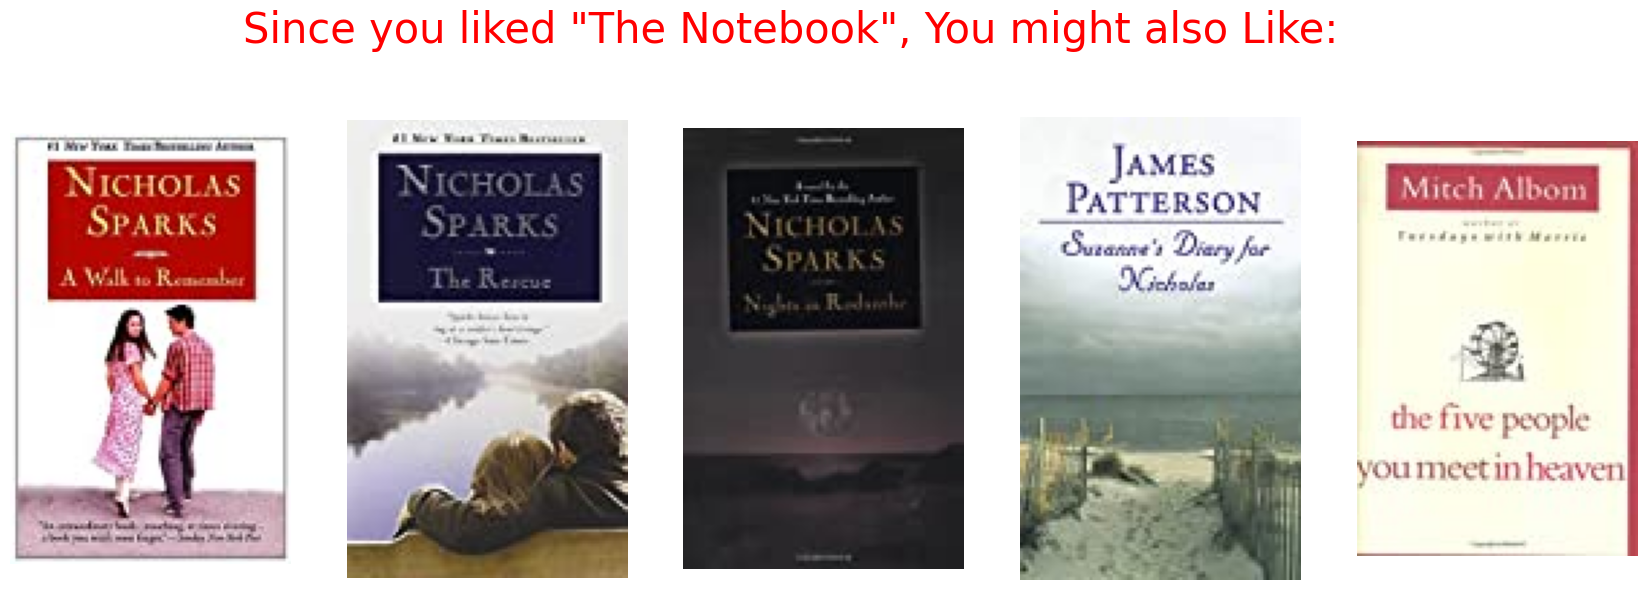

In [54]:
#calling plot function
plot_recommendations(data)

In [ ]:
pickle.dump(top_100,open('top_100.pkl','wb'))